In [6]:
%matplotlib inline
%pprint on

Pretty printing has been turned ON


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import utils
import os
from PIL import Image
import json
import torch
import json
from gensim.models.keyedvectors import KeyedVectors
from types import SimpleNamespace
from networks import TextEncoder, ImageEncoder, DiscourseClassifier
from datasets import CoherenceDataset, val_transform
from torch.utils.data import DataLoader
from tqdm import tqdm
import re
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
import pandas as pd

# Functions

In [8]:
def load_model(args):
    text_encoder = TextEncoder(
        emb_dim=args.word2vec_dim,
        hid_dim=args.rnn_hid_dim,
        z_dim=args.feature_dim,
        max_len = args.max_len,
        word2vec_file=f'models/word2vec_{args.data_source}.bin',
        with_attention=args.with_attention).to(device)
    image_encoder = ImageEncoder(
        z_dim=args.feature_dim).to(device)
    discourse_class = DiscourseClassifier(
        len(args.relations), args.feature_dim).to(device)

    ckpt = torch.load(args.ckpt_path)
    text_encoder.load_state_dict(ckpt['text_encoder'])
    image_encoder.load_state_dict(ckpt['image_encoder'])
    discourse_class.load_state_dict(ckpt['discourse_class'])
    return text_encoder, image_encoder, discourse_class

In [9]:
def generate_output(test_loader, text_encoder, image_encoder, discourse_class, valid_questions):
    txt_feats = []
    img_feats = []
    probs = []
    labels = []
    attns = []
    for batch in tqdm(test_loader):
        for i in range(len(batch)):
            batch[i] = batch[i].to(device)
        txt, txt_len, img, target = batch
        with torch.no_grad():
            txt_feat, attn = text_encoder(txt.long(), txt_len)
            img_feat = image_encoder(img)
            prob = torch.sigmoid(discourse_class(txt_feat, img_feat))[:,valid_questions]
            txt_feats.append(txt_feat.detach().cpu())
            img_feats.append(img_feat.detach().cpu())
            probs.append(prob.detach().cpu())
            if text_encoder.with_attention:
                attns.append(attn.detach().cpu())
            labels.append(target[:,valid_questions].detach().cpu())

    txt_feats = torch.cat(txt_feats, dim=0).numpy()
    img_feats = torch.cat(img_feats, dim=0).numpy()
    probs = torch.cat(probs, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    if text_encoder.with_attention:
        attns = torch.cat(attns, dim=0).numpy()
    return probs, labels, attns, txt_feats, img_feats

In [10]:
def compute_sim_mat(rcp_feats, img_feats, retrieved_type='image'):
    rcp_feats = rcp_feats / np.linalg.norm(rcp_feats, axis=1)[:, None]
    img_feats = img_feats / np.linalg.norm(img_feats, axis=1)[:, None]
    if retrieved_type == 'recipe':
        sims = np.dot(img_feats, rcp_feats.T)  # [N, N]
    else:
        sims = np.dot(rcp_feats, img_feats.T)
    return sims
    
def rank(rcps, imgs, retrieved_type='image', retrieved_range=500, n_repeat=5):
    N = retrieved_range
    data_size = imgs.shape[0]
    idxs = range(N)
    glob_rank = []
    glob_recall = {1: 0.0, 5: 0.0, 10: 0.0}
    # repeat experiments
    for i in range(n_repeat):
        ids_sub = np.random.choice(data_size, N, replace=False)
        imgs_sub = imgs[ids_sub, :]
        rcps_sub = rcps[ids_sub, :]
        sims = compute_sim_mat(rcps_sub, imgs_sub, retrieved_type)
        med_rank = []
        recall = {1: 0.0, 5: 0.0, 10: 0.0}
        # loop through the N similarities for images
        for ii in idxs:
            # get a column of similarities for image ii
            sim = sims[ii, :]
            # sort indices in descending order
            sorting = np.argsort(sim)[::-1].tolist()
            # find where the index of the pair sample ended up in the sorting
            pos = sorting.index(ii)
            if (pos + 1) == 1:
                recall[1] += 1
            if (pos + 1) <= 5:
                recall[5] += 1
            if (pos + 1) <= 10:
                recall[10] += 1
            # store the position
            med_rank.append(pos+1)

        for i in recall.keys():
            recall[i] = recall[i]/N
        med = np.median(med_rank)
        for i in recall.keys():
            glob_recall[i] += recall[i]
        glob_rank.append(med)

    for i in glob_recall.keys():
        glob_recall[i] = glob_recall[i]/10
    return np.asarray(glob_rank), glob_recall

# CITE++

In [11]:
device = 'cuda'
args = {
    'data_source': 'cite',
    'img_dir': '../data/RecipeQA/images-qa/train/images-qa',
    'word2vec_dim': 300,
    'rnn_hid_dim': 300,
    'feature_dim': 1024,
    'max_len': 200,
    'dataset_q': 0,
    'with_attention': 2,
    'batch_size': 64,
    'workers': 4, 
    'relations': ['q2_resp', 'q3_resp', 'q4_resp', 'q5_resp', 'q6_resp', 'q7_resp', 'q8_resp'],
    'valid_questions': [0,1,2,3,4,5,6],
    'ckpt_path': 'runs/samples3439_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=2,3,4,5,6,7,8_maxLen=200/e19.ckpt',
}
args = SimpleNamespace(**args)

## Load Dataset

In [12]:
train_set = CoherenceDataset(
            part='train',
            datasource=args.data_source,
            word2vec_file=f'models/word2vec_{args.data_source}.bin',
            max_len=args.max_len,
            dataset_q=args.dataset_q,  # experimental things, ignore it for now
            transform=val_transform)

train_loader = DataLoader(
            train_set, batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True,
            drop_last=False)

print('train data:', len(train_set), len(train_loader))

test_set = CoherenceDataset(
            part='test',
            datasource=args.data_source,
            word2vec_file=f'models/word2vec_{args.data_source}.bin',
            max_len=args.max_len,
            dataset_q=args.dataset_q,  # experimental things, ignore it for now
            transform=val_transform)

test_loader = DataLoader(
            test_set, batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True,
            drop_last=False)

print('test data:', len(test_set), len(test_loader))

vocab size = 8918
train data: 3439 54
vocab size = 8918
test data: 860 14


## Load Model

In [13]:
valid_questions_all = torch.tensor(args.valid_questions, dtype=torch.long) # all

t_all, i_all, d_all = load_model(args)
probs_train, labels_train, attns_train, txt_train, img_train = generate_output(train_loader, t_all, i_all, d_all, valid_questions_all)
probs_test, labels_test, attns_test, txt_test, img_test = generate_output(test_loader, t_all, i_all, d_all, valid_questions_all)
print(probs_train.shape)
print(probs_test.shape)

100%|██████████| 14/14 [00:06<00:00,  2.12it/s]

(3439, 7)
(860, 7)


In [14]:
retrieved_range = 500
medRs, recalls = rank(
    txt_test, 
    img_test, 
    retrieved_type='image', 
    retrieved_range=retrieved_range,
    n_repeat=50)
medRs.mean(), medRs.std()

(5.03, 1.6535114151405186)

In [15]:
N = 500
ids_sub = np.random.choice(len(txt_test), N, replace=False)
txt_test_sub = torch.tensor(txt_test[ids_sub, :]).to(device)
img_test_sub = torch.tensor(img_test[ids_sub, :]).to(device)

# Compute Similarity Matrix

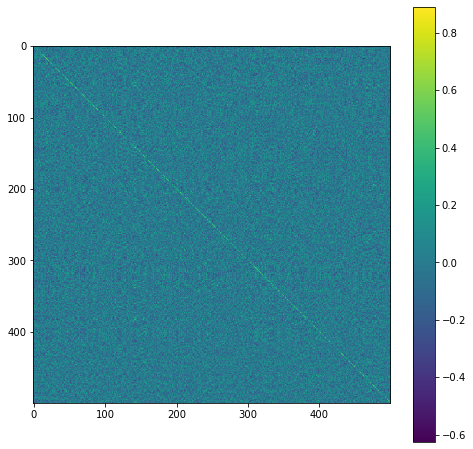

In [16]:
sim_mat = compute_sim_mat(txt_test[ids_sub, :], img_test[ids_sub, :])
plt.figure(figsize=(8,8))
plt.imshow(sim_mat)
plt.colorbar()

3.0

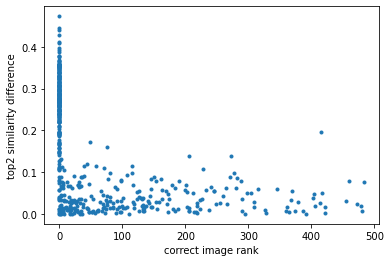

In [17]:
positions = []
means = []
stds = []
diffs = []
for i, sim in enumerate(sim_mat): 
    sorted_idxs = np.argsort(sim).tolist()[::-1]
    sorted_sim = np.sort(sim)[::-1][:10]
    means.append(sorted_sim.mean())
    stds.append(sorted_sim.std())
    diffs.append(sorted_sim[0]-sorted_sim[1])
    pos = sorted_idxs.index(i)
    positions.append(pos)

# plt.figure(figsize=(14,5))
# plt.subplot(131)
# plt.plot(positions, means, '.')
# plt.subplot(132)
# plt.plot(positions, stds, '.')
# plt.subplot(133)
plt.plot(positions, diffs, '.')
plt.xlabel('correct image rank')
plt.ylabel('top2 similarity difference')

np.median(positions)

## Estimate Prior Distribution as a Multi-variate Gaussian Distribution from training data

In [117]:
from scipy.spatial.distance import cdist
M = np.mean(labels_train, axis=0)
V = np.cov(labels_train, rowvar=0)
print(M, V.shape)

[0.82116896 0.11514975 0.3285839  0.19337016 0.15789473 0.58767086
 0.31288165] (7, 7)


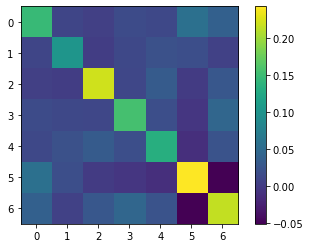

In [118]:
plt.imshow(V)
plt.colorbar()

# Compute Mahalanobis Distance

100%|██████████| 500/500 [00:00<00:00, 1175.68it/s]


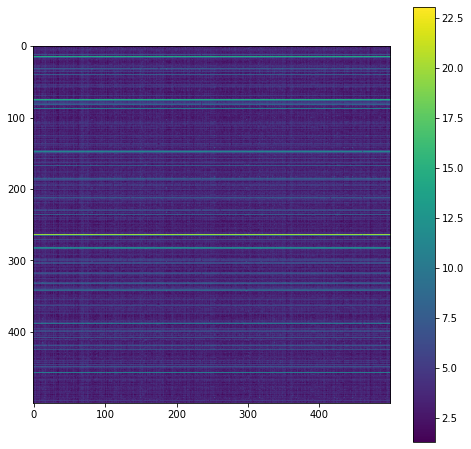

In [176]:
probs = []
mdists = []
with torch.no_grad():
    for i in tqdm(range(len(ids_sub))):
        repeated_txt_feats = txt_test_sub[i:i+1].repeat(N, 1)
        prob = torch.sigmoid(d_all(repeated_txt_feats, img_test_sub))[:,valid_questions_all]
        prob = prob.detach().cpu().numpy()
        pred = prob>0.5
        mdist = cdist(pred, [M], metric='mahalanobis', V=V)[:,0]
        mdists.append(mdist)
    
mdists = np.stack(mdists)
plt.figure(figsize=(8,8))
plt.imshow(mdists)
plt.colorbar()

# Rank using Mahalanobis Distance

234.5

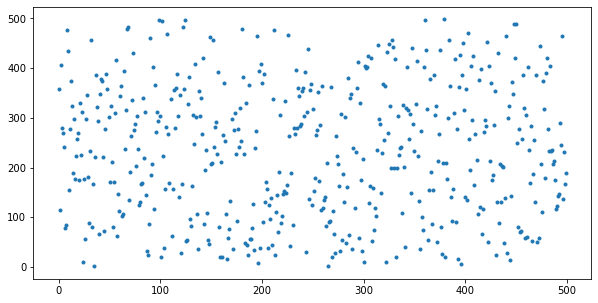

In [177]:
positions = []
for i, mdist in enumerate(mdists): 
    sorted_idxs = np.argsort(mdist).tolist() # increasing order
    pos = sorted_idxs.index(i)
    positions.append(pos)

plt.figure(figsize=(10,5))
plt.plot(positions, '.')
np.median(positions)

## Combine Similarity and Maha dist

In [11]:
sim_recalc = sim_mat / positions
plt.figure(figsize=(12,12))
plt.imshow(sim_recalc)
plt.colorbar()

NameError: name 'sim_mat' is not defined

35.0

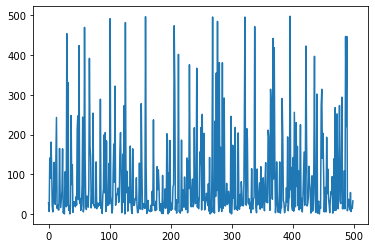

In [179]:
positions_recalc = []
for i, sim in enumerate(sim_recalc): 
    sorted_idxs = np.argsort(sim).tolist()[::-1]
    pos = sorted_idxs.index(i)
    positions_recalc.append(pos)
plt.plot(positions_recalc)
np.median(positions_recalc)

# Calculate Entropy

100%|██████████| 500/500 [00:00<00:00, 1873.15it/s]


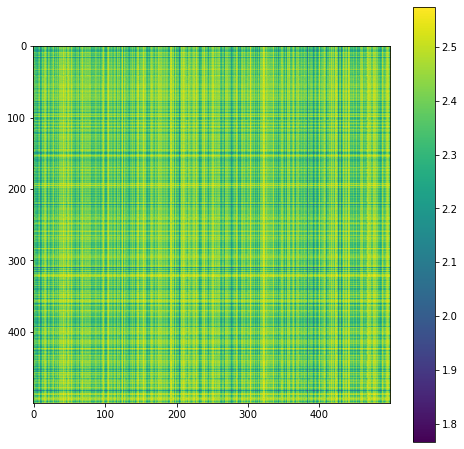

In [24]:
N=500
entropies = []
with torch.no_grad():
    for i in tqdm(range(N)):
        repeated_txt_feats = txt_test_sub[i:i+1].repeat(N, 1)
        prob = torch.sigmoid(d_all(repeated_txt_feats, img_test_sub))[:,valid_questions_all]
        prob = prob.detach().cpu().numpy() # [N, 7]
        entropy = - (prob * np.log(prob)).sum(axis=1) # [N]
        entropies.append(entropy)
entropies = np.stack(entropies)
plt.figure(figsize=(8,8))
plt.imshow(entropies)
plt.colorbar()

## Rank by entropy

210.5

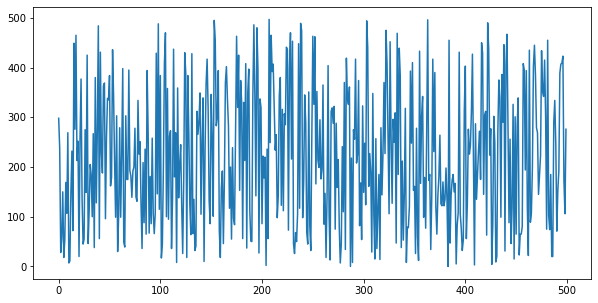

In [25]:
positions_entropy = []
for i, sim in enumerate(entropies): 
    sorted_idxs = np.argsort(sim).tolist()
    pos = sorted_idxs.index(i)
    positions_entropy.append(pos)
    
plt.figure(figsize=(10,5))
plt.plot(positions_entropy)
np.median(positions_entropy)

# Combine Similarity and Entropy

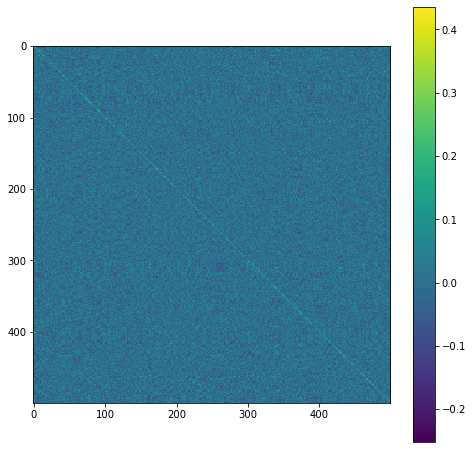

In [26]:
sim_recalc = sim_mat / entropies
plt.figure(figsize=(8,8))
plt.imshow(sim_recalc)
plt.colorbar()

4.5

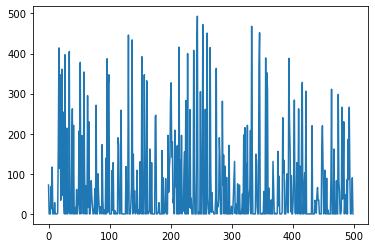

In [27]:
positions_recalc = []
for i, sim in enumerate(sim_recalc): 
    sorted_idxs = np.argsort(sim).tolist()[::-1]
    pos = sorted_idxs.index(i)
    positions_recalc.append(pos)
plt.plot(positions_recalc)
np.median(positions_recalc)

## Compare (Similarity) vs (Similarity+Entropy) side by side

In [206]:
N = 500

medRs = []
medRs_new = []
for _ in tqdm(range(10)):
    ids_sub = np.random.choice(len(txt_test), N, replace=False)
    sim_mat = compute_sim_mat(txt_test[ids_sub, :], img_test[ids_sub, :])
    positions = []
    for i, sim in enumerate(sim_mat): 
        sorted_idxs = np.argsort(sim).tolist()[::-1]
        pos = sorted_idxs.index(i)
        positions.append(pos)
    medRs.append(np.median(positions))

    entropies = []
    with torch.no_grad():
        for i in range(N):
            repeated_txt_feats = txt_test_sub[i:i+1].repeat(N, 1)
            prob = torch.sigmoid(d_all(repeated_txt_feats, img_test_sub))[:,valid_questions_all]
            prob = prob.detach().cpu().numpy() # [N, 7]
            entropy = - (prob * np.log(prob)).sum(axis=1) # [N]
            entropies.append(entropy)
    entropies = np.stack(entropies)
    sim_recalc = sim_mat / entropies
    positions_recalc = []
    for i, sim in enumerate(sim_recalc): 
        sorted_idxs = np.argsort(sim).tolist()[::-1]
        pos = sorted_idxs.index(i)
        positions_recalc.append(pos)
    medRs_new.append(np.median(positions_recalc))
    
print(f'{np.mean(medRs):.2f}, {np.std(medRs):.2f}')
print(f'{np.mean(medRs_new):.2f}, {np.std(medRs_new):.2f}')

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

3.20, 1.14
3.10, 1.22


# Clue

In [212]:
device = 'cuda'
args = {
    'data_source': 'clue',
    'img_dir': '../data/conceptual/images/',
    'word2vec_dim': 300,
    'rnn_hid_dim': 300,
    'feature_dim': 1024,
    'max_len': 40,
    'dataset_q': 0,
    'with_attention': 2,
    'batch_size': 64,
    'workers': 4, 
    'relations': ['Visible', 'Subjective', 'Action', 'Story', 'Meta', 'Irrelevant'],
    'valid_questions': [0,1,2,3,4,5],
    'ckpt_path': 'runs/samples6047_retrieval=1.00_classification=0.10_reweight=1000.00_weightDecay=0.0_withAttention=2_question=0,1,2,3,4,5_maxLen=40/e19.ckpt',
}
args = SimpleNamespace(**args)

## Load Dataset

In [38]:
train_set = CoherenceDataset(
            part='train',
            datasource=args.data_source,
            word2vec_file=f'models/word2vec_{args.data_source}.bin',
            max_len=args.max_len,
            dataset_q=args.dataset_q,  # experimental things, ignore it for now
            transform=val_transform)

train_loader = DataLoader(
            train_set, batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True,
            drop_last=False)

print('train data:', len(train_set), len(train_loader))

test_set = CoherenceDataset(
            part='test',
            datasource=args.data_source,
            word2vec_file=f'models/word2vec_{args.data_source}.bin',
            max_len=args.max_len,
            dataset_q=args.dataset_q,  # experimental things, ignore it for now
            transform=val_transform)

test_loader = DataLoader(
            test_set, batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True,
            drop_last=False)

print('test data:', len(test_set), len(test_loader))

vocab size = 8918
train data: 3439 54
vocab size = 8918
test data: 860 14


## Load Model

In [39]:
valid_questions_all = torch.tensor(args.valid_questions, dtype=torch.long) # all

t_all, i_all, d_all = load_model(args)
# probs_train, labels_train, attns_train, txt_train, img_train = generate_output(train_loader, t_all, i_all, d_all, valid_questions_all)
probs_test, labels_test, attns_test, txt_test, img_test = generate_output(test_loader, t_all, i_all, d_all, valid_questions_all)
print(probs_train.shape)
print(probs_test.shape)

100%|██████████| 14/14 [00:07<00:00,  1.99it/s]

(3439, 7)
(860, 7)


## Compare (Similarity) vs (Similarity+Entropy) side by side

In [230]:
N = 500

medRs = []
medRs_new = []
for _ in tqdm(range(10)):
    ids_sub = np.random.choice(len(txt_test), N, replace=False)
    sim_mat = compute_sim_mat(txt_test[ids_sub, :], img_test[ids_sub, :])
    positions = []
    for i, sim in enumerate(sim_mat): 
        sorted_idxs = np.argsort(sim).tolist()[::-1]
        pos = sorted_idxs.index(i)
        positions.append(pos)
    medRs.append(np.median(positions))

    entropies = []
    with torch.no_grad():
        for i in range(N):
            repeated_txt_feats = txt_test_sub[i:i+1].repeat(N, 1)
            prob = torch.sigmoid(d_all(repeated_txt_feats, img_test_sub))[:,valid_questions_all]
            prob = prob.detach().cpu().numpy() # [N, 7]
            entropy = - (prob * np.log(prob)).sum(axis=1) # [N]
            entropies.append(entropy)
    entropies = np.stack(entropies)
    sim_recalc = sim_mat / entropies
    positions_recalc = []
    for i, sim in enumerate(sim_recalc): 
        sorted_idxs = np.argsort(sim).tolist()[::-1]
        pos = sorted_idxs.index(i)
        positions_recalc.append(pos)
    medRs_new.append(np.median(positions_recalc))
    
print(f'{np.mean(medRs):.2f}, {np.std(medRs):.2f}')
print(f'{np.mean(medRs_new):.2f}, {np.std(medRs_new):.2f}')

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

20.15, 1.76
20.00, 1.67
